# Event Classification for Belle 2 Data
This notebook showcases the project by Group 23 for the IDC409 term project

**Authors:**

Darsh A (MS22068)

Swalih (MS22132)

Rida Haris (MS22023)

Abhiram Srinivas (MS22093)

The aim of this project was to find the single best model for classifying signal and background from the event data. The data is configured into 6 different types:
$$e^+ e^- \to \Upsilon (4S) \to B^+ B^- = \text{Type 0}$$

$$e^+ e^- \to \Upsilon(4S) \to B^0 \bar{B}^0 = \text{Type 1}$$

$$e^+ e^- \to c \bar{c} = \text{Type 2}$$

$$e^+ e^- \to u \bar{u} = \text{Type 3}$$

$$e^+ e^- \to d \bar{d} = \text{Type 4}$$

$$e^+ e^- \to s \bar{s} = \text{Type 5} $$


From here on, Type 0 and 1 will be refered to as _signal_ and Type 2,3,4,5 will be refered to as _background_

The data describes these events with the help of various variables that are tied to the property of the event. The variables are pre-engineered and the data is generated by [Monte Carlo Simulation](https://training.belle2.org/online_book/basf2/cs.html?utm_=)   using the basf2 software where the classification was done by a pretrained [FastBDT](https://github.com/thomaskeck/FastBDT) model 

## Initialize

In [79]:
%load_ext autoreload
%autoreload 2

import sys, os
src_path = os.path.join(os.getcwd(), "src")
if src_path not in sys.path:
    sys.path.insert(0, src_path)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from src.utils import Utils
from src.data_anan import DataPreprocessing

df = Utils.data_import('data/data_hep - data_hep.csv')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Visualization

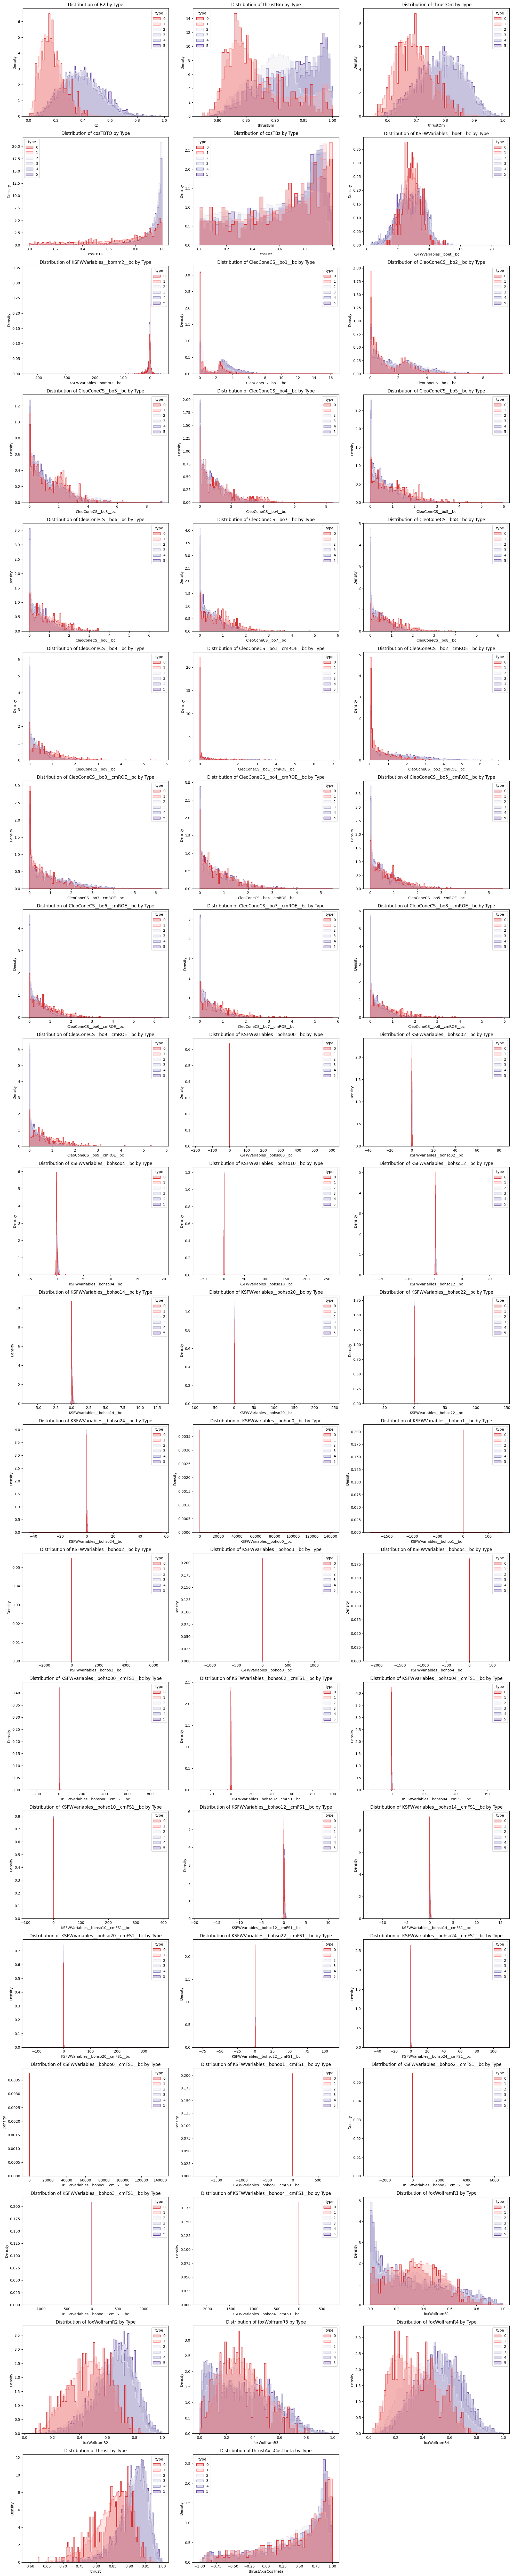

In [80]:
signal_colors = ["#d62728", "#ff9896"]   # deep red, soft salmon
background_colors = sns.color_palette("Purples", n_colors=4)  # 4 shades of purple

custom_palette = {
    0: signal_colors[0],   # type 0
    1: signal_colors[1],   # type 1
    2: background_colors[0],
    3: background_colors[1],
    4: background_colors[2],
    5: background_colors[3],
}

features = df.drop(columns=['index', 'type'])

num_features = features.shape[1]
num_cols = 3
num_rows = (num_features + num_cols - 1) // num_cols

plt.figure(figsize=(20, num_rows * 5))
for i, column in enumerate(features.columns):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.histplot(
        data=df,
        x=column,
        hue='type',
        element='step',
        stat='density',
        common_norm=False,
        palette=custom_palette
    )
    plt.title(f'Distribution of {column} by Type')

plt.tight_layout()
# plt.savefig("feature_distributions_by_type.png")
plt.show()


By looking at the above plots two things are clear

1. Some features show clear bimodality between the signal and background (red and purple curves)

2. Some features showing sharp overlapped spikes means these features do not contribute to the classification of the types much

This calls for the use of Decision Trees for the classification and then using some form of variable/dimension reduction to improve the performance and efficiency

## Model Training

We have chosen 5 Decision Tree based models which are an improvement of each previous one of them
1. Decision Trees
2. Random Forest
3. XGBoost
4. FastBDT
5. LightGBM

In [81]:
from src.fastbdt import train_fastbdt, randomized_search_fastbdt
from src.dts import train_decision_tree, train_random_forest
from src.xgb_model import train_xgboost, randomized_search_xgboost
from src.lgbm_model import train_lightgbm, randomized_search_lightgbm

In [82]:
X, y = Utils.bin_classification(df)
X_train, X_test, y_train, y_test = Utils.data_split(X, y, ratio=0.3)
initial_data = X, y, X_train, X_test, y_train, y_test

The models go through initial training on entire data with no variable reduction to first form a baseline and also then get feature importance so we can further reduce the features based on that. The initial models will be refered to as M1 from now on

The models are already hypertuned for the best performance and the results are saved in `best_model_params.json`. To train them again, one can use the param `tune_hyperparameters=True`

In [83]:
dt_results = train_decision_tree(
    data = initial_data,
    model_name='decision_tree_model_initial'
)

rf_results = train_random_forest(
    data = initial_data,
    model_name='random_forest_model_initial'
)

xgb_results = train_xgboost(
    data = initial_data,
    model_name='xgboost_model_initial'
)

fbdt_results = train_fastbdt(
    data = initial_data,
    model_name='fastbdt_model_initial'
)

lgbm_results = train_lightgbm(
    data = initial_data,
    model_name='lightgbm_model_initial'
)


Decision Tree - Total features: 59
Saved Decision Tree model to models/decision_tree_model_initial.pkl

Random Forest - Total features: 59
Saved Random Forest model to models/random_forest_model_initial.pkl

XGBoost - Total features: 59

FastBDT - Total features: 59
✅ CUDA is available - LightGBM will use GPU
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	train's auc: 0.975534	val's auc: 0.950964

LightGBM - Total features: 59


In [84]:
print("DT Accuracy:", dt_results['accuracy'])
print("RF Accuracy:", rf_results['accuracy'])
print("XGB Accuracy:", xgb_results['accuracy'])
print("FBDT Accuracy:", fbdt_results['accuracy'])
print("LGBM Accuracy:", lgbm_results['accuracy'])
print("===============================================")
# print auc score
print("DT AUC:", dt_results['roc_auc_score'])
print("RF AUC:", rf_results['roc_auc_score'])
print("XGB AUC:", xgb_results['roc_auc_score'])
print("FBDT AUC:", fbdt_results['roc_auc_score'])
print("LGBM AUC:", lgbm_results['roc_auc_score'])
print("===============================================")
# print training time
print("DT Training Time:", dt_results['training_time'])
print("RF Training Time:", rf_results['training_time'])
print("XGB Training Time:", xgb_results['training_time'])
print("FBDT Training Time:", fbdt_results['training_time'])
print("LGBM Training Time:", lgbm_results['training_time'])


DT Accuracy: 0.8337267491266169
RF Accuracy: 0.8485034463223492
XGB Accuracy: 0.8779624209234256
FBDT Accuracy: 0.8761684449060523
LGBM Accuracy: 0.8764517042772165
DT AUC: 0.9096898563316473
RF AUC: 0.9247150511689884
XGB AUC: 0.9492826568997439
FBDT AUC: 0.9467002261971382
LGBM AUC: 0.9483223266419356
DT Training Time: 6.927748918533325
RF Training Time: 9.97311782836914
XGB Training Time: 4.856767892837524
FBDT Training Time: 7.391096591949463
LGBM Training Time: 12.936541080474854


Model: Decision Tree | Area Under ROC Curve (AUC): 0.9096899
Model: Random Forest | Area Under ROC Curve (AUC): 0.9247151
Model: XGBoost | Area Under ROC Curve (AUC): 0.9492827
Model: FastBDT | Area Under ROC Curve (AUC): 0.9467002
Model: LightGBM | Area Under ROC Curve (AUC): 0.9483223

Generating ROC curve comparison plot...
Plot saved as 'plots/roc_comparison.png'


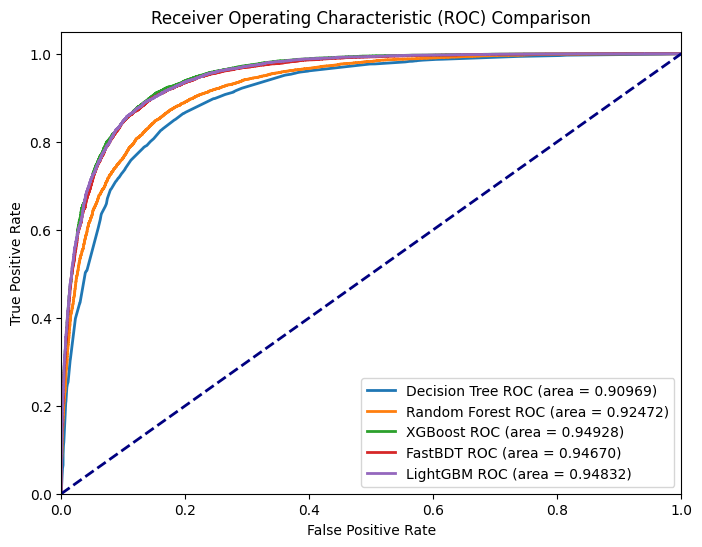

In [85]:
dt_roc = dt_results['roc_curve']
rf_roc = rf_results['roc_curve']
xgb_roc = xgb_results['roc_curve']
fbdt_roc = fbdt_results['roc_curve']
lgbm_roc = lgbm_results['roc_curve']


Utils.plot_roc_comparison(
    [('Decision Tree', dt_roc),
     ('Random Forest', rf_roc),
     ('XGBoost', xgb_roc),
     ('FastBDT', fbdt_roc),
     ('LightGBM', lgbm_roc)],
    plotname='roc_comparison.png'
)

Our results shows use the BDT methods perform much better than DTs and Random Forest (as they should)

While also XGBoost being the best performing model accuracy and performance wise

## Dimensionality Reduction

Now that we have found the best model using the entire dataset, lets try to better them by improving the data provided to them.

We tried and compared few commmonly used methods for variable reduction:
1. **RFECV** - Recursive Feature Elimination with Cross-Validation
2. **Permutation Importance** - Feature importance via permutation
3. **SHAP** - SHAP value-based importance
4. **Mutual Information** - Statistical dependency measure
5. **SelectFromModel** - Various importance thresholds
6. **Variance Threshold** - Remove low-variance features
7. **Correlation-based** - Remove highly correlated features

In [ ]:
"""
WARNING: The following cell will take 10-15 minutes to run depending on the machine
The results are saved in `retraining_runtime_vs_performance.csv` so that it can be used later without running the cell again
And the result plot is saved in plots/feature_selection_runtime_vs_performance.png
"""


# Set default parameters
importance_threshold = 0.0
n_estimators = 100
max_depth = 6
random_state = 42

# Suppress all print statements
import sys
import os
from contextlib import redirect_stdout

with redirect_stdout(open(os.devnull, 'w')):
    # Run the feature reduction analysis
    exec(open('src/feature_red.py').read())


From Multiple runs we see that `Correlation` performs the best, thus we shall retrain the models on this method

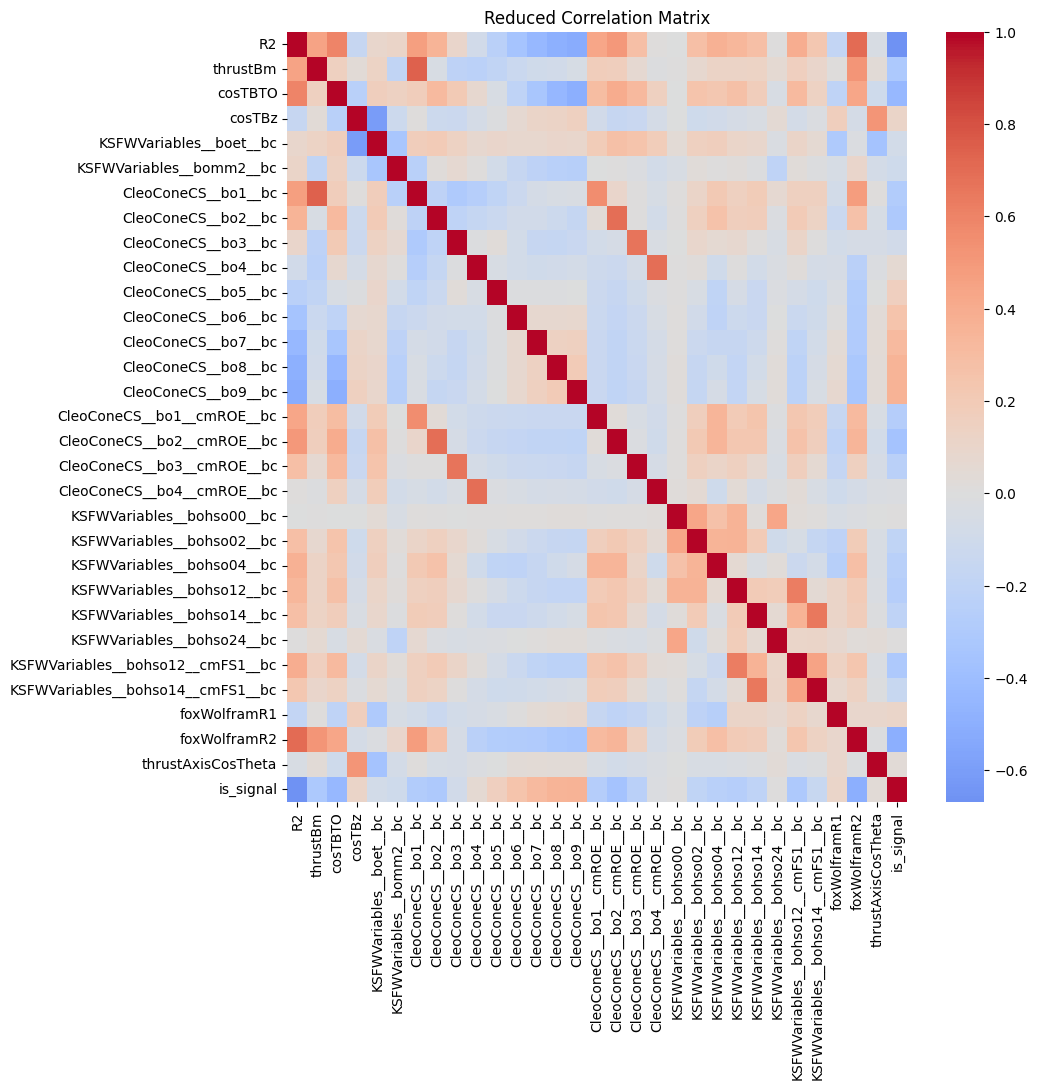


Original number of features: 59
Reduced number of features: 30
Features removed: 29

Selected features (30): ['R2', 'thrustBm', 'cosTBTO', 'cosTBz', 'KSFWVariables__boet__bc', 'KSFWVariables__bomm2__bc', 'CleoConeCS__bo1__bc', 'CleoConeCS__bo2__bc', 'CleoConeCS__bo3__bc', 'CleoConeCS__bo4__bc', 'CleoConeCS__bo5__bc', 'CleoConeCS__bo6__bc', 'CleoConeCS__bo7__bc', 'CleoConeCS__bo8__bc', 'CleoConeCS__bo9__bc', 'CleoConeCS__bo1__cmROE__bc', 'CleoConeCS__bo2__cmROE__bc', 'CleoConeCS__bo3__cmROE__bc', 'CleoConeCS__bo4__cmROE__bc', 'KSFWVariables__bohso00__bc', 'KSFWVariables__bohso02__bc', 'KSFWVariables__bohso04__bc', 'KSFWVariables__bohso12__bc', 'KSFWVariables__bohso14__bc', 'KSFWVariables__bohso24__bc', 'KSFWVariables__bohso12__cmFS1__bc', 'KSFWVariables__bohso14__cmFS1__bc', 'foxWolframR1', 'foxWolframR2', 'thrustAxisCosTheta']


In [87]:
# Apply correlation-based feature reduction
correlation_threshold = 0.8

# Get reduced features using correlation
reduced_features_df = DataPreprocessing.data_reduction_correlation(df, threshold=correlation_threshold, preview=True)

# CRITICAL: Remove 'is_signal' if it exists (it's the target, not a feature!)
if 'is_signal' in reduced_features_df.columns:
    reduced_features_df = reduced_features_df.drop(columns=['is_signal'])

print(f"\nOriginal number of features: {len(df.drop(columns=['index', 'type', 'is_signal']).columns)}")
print(f"Reduced number of features: {len(reduced_features_df.columns)}")
print(f"Features removed: {len(df.drop(columns=['index', 'type', 'is_signal']).columns) - len(reduced_features_df.columns)}")

# Get the list of selected features for retraining
selected_features_corr = reduced_features_df.columns.tolist()
print(f"\nSelected features ({len(selected_features_corr)}): {selected_features_corr}")


In [88]:
# Prepare data with reduced features
X_corr = reduced_features_df
y_corr = df['is_signal']

# Split the data
X_train_corr, X_test_corr, y_train_corr, y_test_corr = Utils.data_split(X_corr, y_corr, ratio=0.3)
corr_data = X_corr, y_corr, X_train_corr, X_test_corr, y_train_corr, y_test_corr

print(f"Training set shape: {X_train_corr.shape}")
print(f"Test set shape: {X_test_corr.shape}")
print(f"Number of features: {X_train_corr.shape[1]}")


Training set shape: (49424, 30)
Test set shape: (21182, 30)
Number of features: 30


In [89]:
# Retrain all models with correlation-reduced features (M2)
print("=" * 80)
print("RETRAINING MODELS WITH CORRELATION-BASED FEATURE REDUCTION (M2)")
print("=" * 80)

dt_results_corr = train_decision_tree(
    data=corr_data,
    model_name='decision_tree_model_correlation'
)

rf_results_corr = train_random_forest(
    data=corr_data,
    model_name='random_forest_model_correlation'
)

xgb_results_corr = train_xgboost(
    data=corr_data,
    model_name='xgboost_model_correlation'
)

fbdt_results_corr = train_fastbdt(
    data=corr_data,
    model_name='fastbdt_model_correlation'
)

lgbm_results_corr = train_lightgbm(
    data=corr_data,
    model_name='lightgbm_model_correlation'
)

print("\n" + "=" * 80)
print("M2 TRAINING COMPLETE")
print("=" * 80)


RETRAINING MODELS WITH CORRELATION-BASED FEATURE REDUCTION (M2)

Decision Tree - Total features: 30
Saved Decision Tree model to models/decision_tree_model_correlation.pkl

Random Forest - Total features: 30
Saved Random Forest model to models/random_forest_model_correlation.pkl

XGBoost - Total features: 30

FastBDT - Total features: 30
✅ CUDA is available - LightGBM will use GPU
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[492]	train's auc: 0.970865	val's auc: 0.948146

LightGBM - Total features: 30

M2 TRAINING COMPLETE


In [90]:
# Display M2 results
print("M2 MODEL RESULTS (Correlation-based Feature Reduction)")
print("=" * 80)
print("DT Accuracy:", dt_results_corr['accuracy'])
print("RF Accuracy:", rf_results_corr['accuracy'])
print("XGB Accuracy:", xgb_results_corr['accuracy'])
print("FBDT Accuracy:", fbdt_results_corr['accuracy'])
print("LGBM Accuracy:", lgbm_results_corr['accuracy'])
print("=" * 80)
print("DT AUC:", dt_results_corr['roc_auc_score'])
print("RF AUC:", rf_results_corr['roc_auc_score'])
print("XGB AUC:", xgb_results_corr['roc_auc_score'])
print("FBDT AUC:", fbdt_results_corr['roc_auc_score'])
print("LGBM AUC:", lgbm_results_corr['roc_auc_score'])
print("=" * 80)
print("DT Training Time:", dt_results_corr['training_time'])
print("RF Training Time:", rf_results_corr['training_time'])
print("XGB Training Time:", xgb_results_corr['training_time'])
print("FBDT Training Time:", fbdt_results_corr['training_time'])
print("LGBM Training Time:", lgbm_results_corr['training_time'])


M2 MODEL RESULTS (Correlation-based Feature Reduction)
DT Accuracy: 0.8313662543669154
RF Accuracy: 0.8457652724010952
XGB Accuracy: 0.8741856293079029
FBDT Accuracy: 0.86993673874044
LGBM Accuracy: 0.8718723444433953
DT AUC: 0.9086740913683785
RF AUC: 0.9229519653863453
XGB AUC: 0.9459005959520628
FBDT AUC: 0.9443229805877773
LGBM AUC: 0.945021656717488
DT Training Time: 3.6095316410064697
RF Training Time: 7.312053442001343
XGB Training Time: 3.222393274307251
FBDT Training Time: 3.971369504928589
LGBM Training Time: 12.442702293395996


### Performance Comparison: M1 (Initial) vs M2 (Correlation-based Feature Reduction)


In [91]:
# Compare results
comparison_data = {
    'Model': ['Decision Tree', 'Random Forest', 'XGBoost', 'FastBDT', 'LightGBM'],
    'M1_Accuracy': [
        dt_results['accuracy'],
        rf_results['accuracy'],
        xgb_results['accuracy'],
        fbdt_results['accuracy'],
        lgbm_results['accuracy']
    ],
    'M2_Accuracy': [
        dt_results_corr['accuracy'],
        rf_results_corr['accuracy'],
        xgb_results_corr['accuracy'],
        fbdt_results_corr['accuracy'],
        lgbm_results_corr['accuracy']
    ],
    'M1_AUC': [
        dt_results['roc_auc_score'],
        rf_results['roc_auc_score'],
        xgb_results['roc_auc_score'],
        fbdt_results['roc_auc_score'],
        lgbm_results['roc_auc_score']
    ],
    'M2_AUC': [
        dt_results_corr['roc_auc_score'],
        rf_results_corr['roc_auc_score'],
        xgb_results_corr['roc_auc_score'],
        fbdt_results_corr['roc_auc_score'],
        lgbm_results_corr['roc_auc_score']
    ],
    'M1_Time': [
        dt_results['training_time'],
        rf_results['training_time'],
        xgb_results['training_time'],
        fbdt_results['training_time'],
        lgbm_results['training_time']
    ],
    'M2_Time': [
        dt_results_corr['training_time'],
        rf_results_corr['training_time'],
        xgb_results_corr['training_time'],
        fbdt_results_corr['training_time'],
        lgbm_results_corr['training_time']
    ]
}

comparison_df = pd.DataFrame(comparison_data)

# Calculate improvements
comparison_df['Accuracy_Diff'] = comparison_df['M2_Accuracy'] - comparison_df['M1_Accuracy']
comparison_df['AUC_Diff'] = comparison_df['M2_AUC'] - comparison_df['M1_AUC']
comparison_df['Time_Speedup'] = comparison_df['M1_Time'] / comparison_df['M2_Time']

print("=" * 100)
print("PERFORMANCE COMPARISON: M1 (59 features) vs M2 (Correlation-based Feature Reduction)")
print("=" * 100)
print(f"\nFeature Reduction: 59 → {len(selected_features_corr)} features ({len(selected_features_corr)/59*100:.1f}%)")
print("\n" + "=" * 100)
print(f"{'Model':<15} {'M1 Acc':>8} {'M2 Acc':>8} {'Δ Acc':>8} {'M1 AUC':>8} {'M2 AUC':>8} {'Δ AUC':>8} {'M1 Time':>9} {'M2 Time':>9} {'Speedup':>8}")
print("=" * 100)

for idx, row in comparison_df.iterrows():
    acc_symbol = '↑' if row['Accuracy_Diff'] > 0 else '↓' if row['Accuracy_Diff'] < 0 else '='
    auc_symbol = '↑' if row['AUC_Diff'] > 0 else '↓' if row['AUC_Diff'] < 0 else '='
    
    print(f"{row['Model']:<15} {row['M1_Accuracy']:>8.4f} {row['M2_Accuracy']:>8.4f} "
          f"{acc_symbol}{abs(row['Accuracy_Diff']):>7.4f} {row['M1_AUC']:>8.4f} {row['M2_AUC']:>8.4f} "
          f"{auc_symbol}{abs(row['AUC_Diff']):>7.4f} {row['M1_Time']:>8.2f}s {row['M2_Time']:>8.2f}s "
          f"{row['Time_Speedup']:>7.2f}x")

print("=" * 100)


PERFORMANCE COMPARISON: M1 (59 features) vs M2 (Correlation-based Feature Reduction)

Feature Reduction: 59 → 30 features (50.8%)

Model             M1 Acc   M2 Acc    Δ Acc   M1 AUC   M2 AUC    Δ AUC   M1 Time   M2 Time  Speedup
Decision Tree     0.8337   0.8314 ↓ 0.0024   0.9097   0.9087 ↓ 0.0010     6.93s     3.61s    1.92x
Random Forest     0.8485   0.8458 ↓ 0.0027   0.9247   0.9230 ↓ 0.0018     9.97s     7.31s    1.36x
XGBoost           0.8780   0.8742 ↓ 0.0038   0.9493   0.9459 ↓ 0.0034     4.86s     3.22s    1.51x
FastBDT           0.8762   0.8699 ↓ 0.0062   0.9467   0.9443 ↓ 0.0024     7.39s     3.97s    1.86x
LightGBM          0.8765   0.8719 ↓ 0.0046   0.9483   0.9450 ↓ 0.0033    12.94s    12.44s    1.04x


### ROC Curve Comparison: M2 Models


Model: Decision Tree (Corr) | Area Under ROC Curve (AUC): 0.9086741
Model: Random Forest (Corr) | Area Under ROC Curve (AUC): 0.9229520
Model: XGBoost (Corr) | Area Under ROC Curve (AUC): 0.9459006
Model: FastBDT (Corr) | Area Under ROC Curve (AUC): 0.9443230
Model: LightGBM (Corr) | Area Under ROC Curve (AUC): 0.9450217

Generating ROC curve comparison plot...
Plot saved as 'plots/roc_comparison_correlation.png'


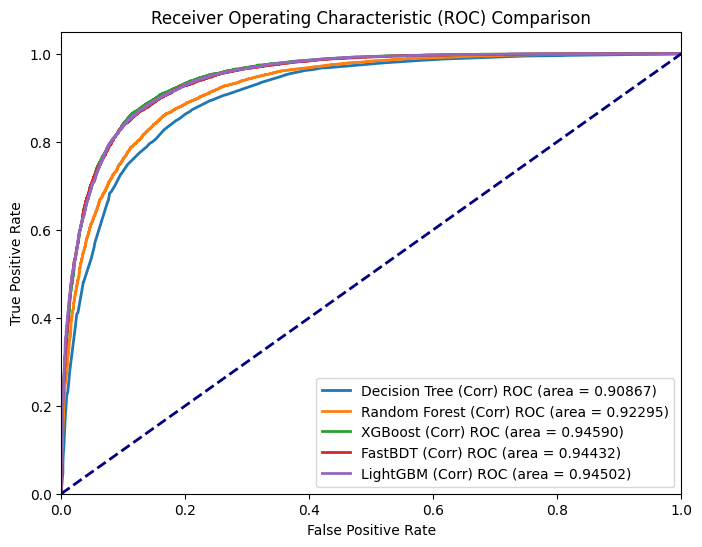

In [92]:
# Plot ROC curves for M2 models
dt_roc_corr = dt_results_corr['roc_curve']
rf_roc_corr = rf_results_corr['roc_curve']
xgb_roc_corr = xgb_results_corr['roc_curve']
fbdt_roc_corr = fbdt_results_corr['roc_curve']
lgbm_roc_corr = lgbm_results_corr['roc_curve']

Utils.plot_roc_comparison(
    [('Decision Tree (Corr)', dt_roc_corr),
     ('Random Forest (Corr)', rf_roc_corr),
     ('XGBoost (Corr)', xgb_roc_corr),
     ('FastBDT (Corr)', fbdt_roc_corr),
     ('LightGBM (Corr)', lgbm_roc_corr)],
    plotname='roc_comparison_correlation.png'
)


### Visualization: Performance Improvements


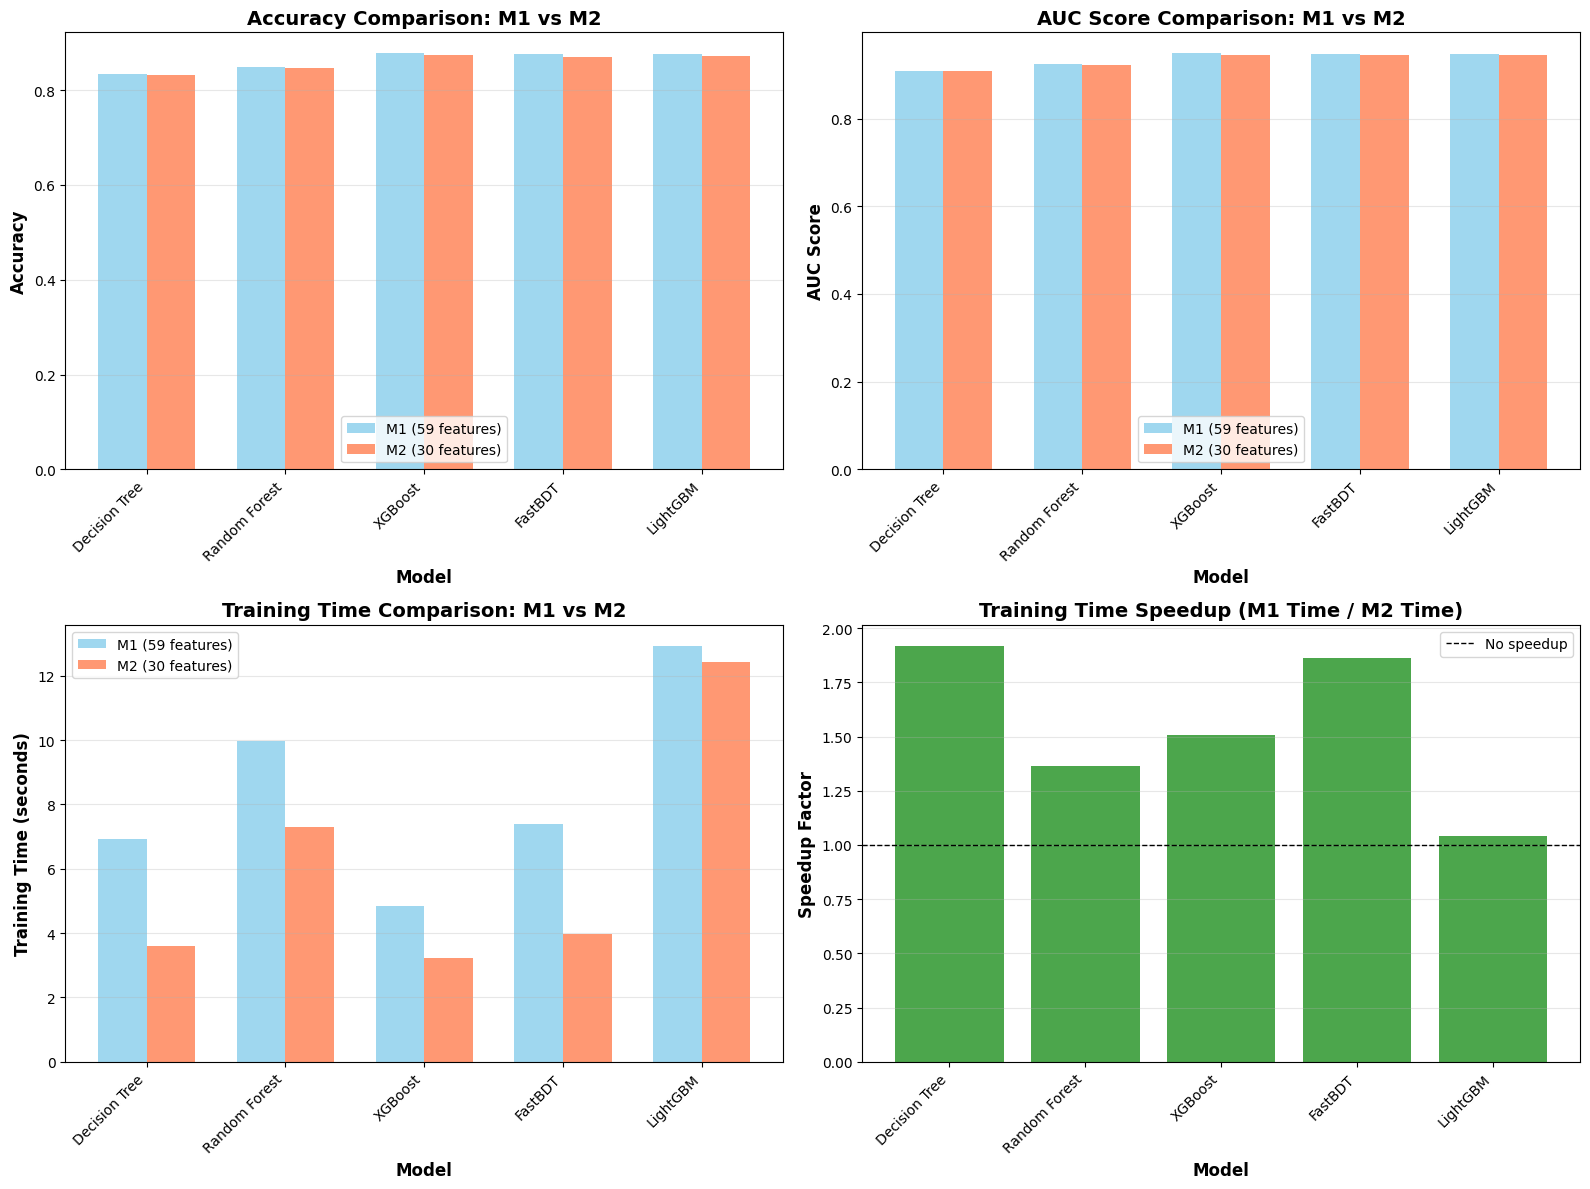

In [93]:
# Create visualization comparing M1 vs M2
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Accuracy Comparison
ax1 = axes[0, 0]
x = np.arange(len(comparison_df['Model']))
width = 0.35
bars1 = ax1.bar(x - width/2, comparison_df['M1_Accuracy'], width, label='M1 (59 features)', alpha=0.8, color='skyblue')
bars2 = ax1.bar(x + width/2, comparison_df['M2_Accuracy'], width, label=f'M2 ({len(selected_features_corr)} features)', alpha=0.8, color='coral')
ax1.set_xlabel('Model', fontsize=12, fontweight='bold')
ax1.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('Accuracy Comparison: M1 vs M2', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Plot 2: AUC Comparison
ax2 = axes[0, 1]
bars1 = ax2.bar(x - width/2, comparison_df['M1_AUC'], width, label='M1 (59 features)', alpha=0.8, color='skyblue')
bars2 = ax2.bar(x + width/2, comparison_df['M2_AUC'], width, label=f'M2 ({len(selected_features_corr)} features)', alpha=0.8, color='coral')
ax2.set_xlabel('Model', fontsize=12, fontweight='bold')
ax2.set_ylabel('AUC Score', fontsize=12, fontweight='bold')
ax2.set_title('AUC Score Comparison: M1 vs M2', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# Plot 3: Training Time Comparison
ax3 = axes[1, 0]
bars1 = ax3.bar(x - width/2, comparison_df['M1_Time'], width, label='M1 (59 features)', alpha=0.8, color='skyblue')
bars2 = ax3.bar(x + width/2, comparison_df['M2_Time'], width, label=f'M2 ({len(selected_features_corr)} features)', alpha=0.8, color='coral')
ax3.set_xlabel('Model', fontsize=12, fontweight='bold')
ax3.set_ylabel('Training Time (seconds)', fontsize=12, fontweight='bold')
ax3.set_title('Training Time Comparison: M1 vs M2', fontsize=14, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# Plot 4: Speedup Factor
ax4 = axes[1, 1]
colors = ['green' if s > 1 else 'red' for s in comparison_df['Time_Speedup']]
bars = ax4.bar(x, comparison_df['Time_Speedup'], color=colors, alpha=0.7)
ax4.axhline(y=1, color='black', linestyle='--', linewidth=1, label='No speedup')
ax4.set_xlabel('Model', fontsize=12, fontweight='bold')
ax4.set_ylabel('Speedup Factor', fontsize=12, fontweight='bold')
ax4.set_title('Training Time Speedup (M1 Time / M2 Time)', fontsize=14, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
# plt.savefig('plots/correlation_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


# Conclusion

Thus we see that ***XGBoost performs better than rest*** of the model giving us the best performance vs accuracy for our binary classification on both non-redcued and reduced dataset

Here we show the final model with useful metrics

In [95]:
# Save the best model
import os
import pickle

# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save the XGBoost model (best model)
best_model = xgb_results_corr['model']
best_model_path = 'models/best_model.json'
best_model.save_model(best_model_path)
print(f"✅ Best model saved to {best_model_path}")

# Also save as pickle for easy loading
with open('models/best_model.pkl', 'wb') as f:
    pickle.dump(xgb_results_corr, f)
print(f"✅ Complete results saved to models/best_model.pkl")

# Display key metrics
print("\n" + "=" * 80)
print("BEST MODEL PERFORMANCE (XGBoost with Correlation-based Feature Reduction)")
print("=" * 80)
print(f"Accuracy:        {xgb_results_corr['accuracy']:.4f}")
print(f"ROC-AUC Score:   {xgb_results_corr['roc_auc_score']:.6f}")
print(f"Training Time:   {xgb_results_corr['training_time']:.2f} seconds")
print(f"Features Used:   {len(selected_features_corr)} out of 59")
print("=" * 80)


✅ Best model saved to models/best_model.json
✅ Complete results saved to models/best_model.pkl

BEST MODEL PERFORMANCE (XGBoost with Correlation-based Feature Reduction)
Accuracy:        0.8742
ROC-AUC Score:   0.945901
Training Time:   3.22 seconds
Features Used:   30 out of 59


✅ Visualization saved to plots/best_model_results.png


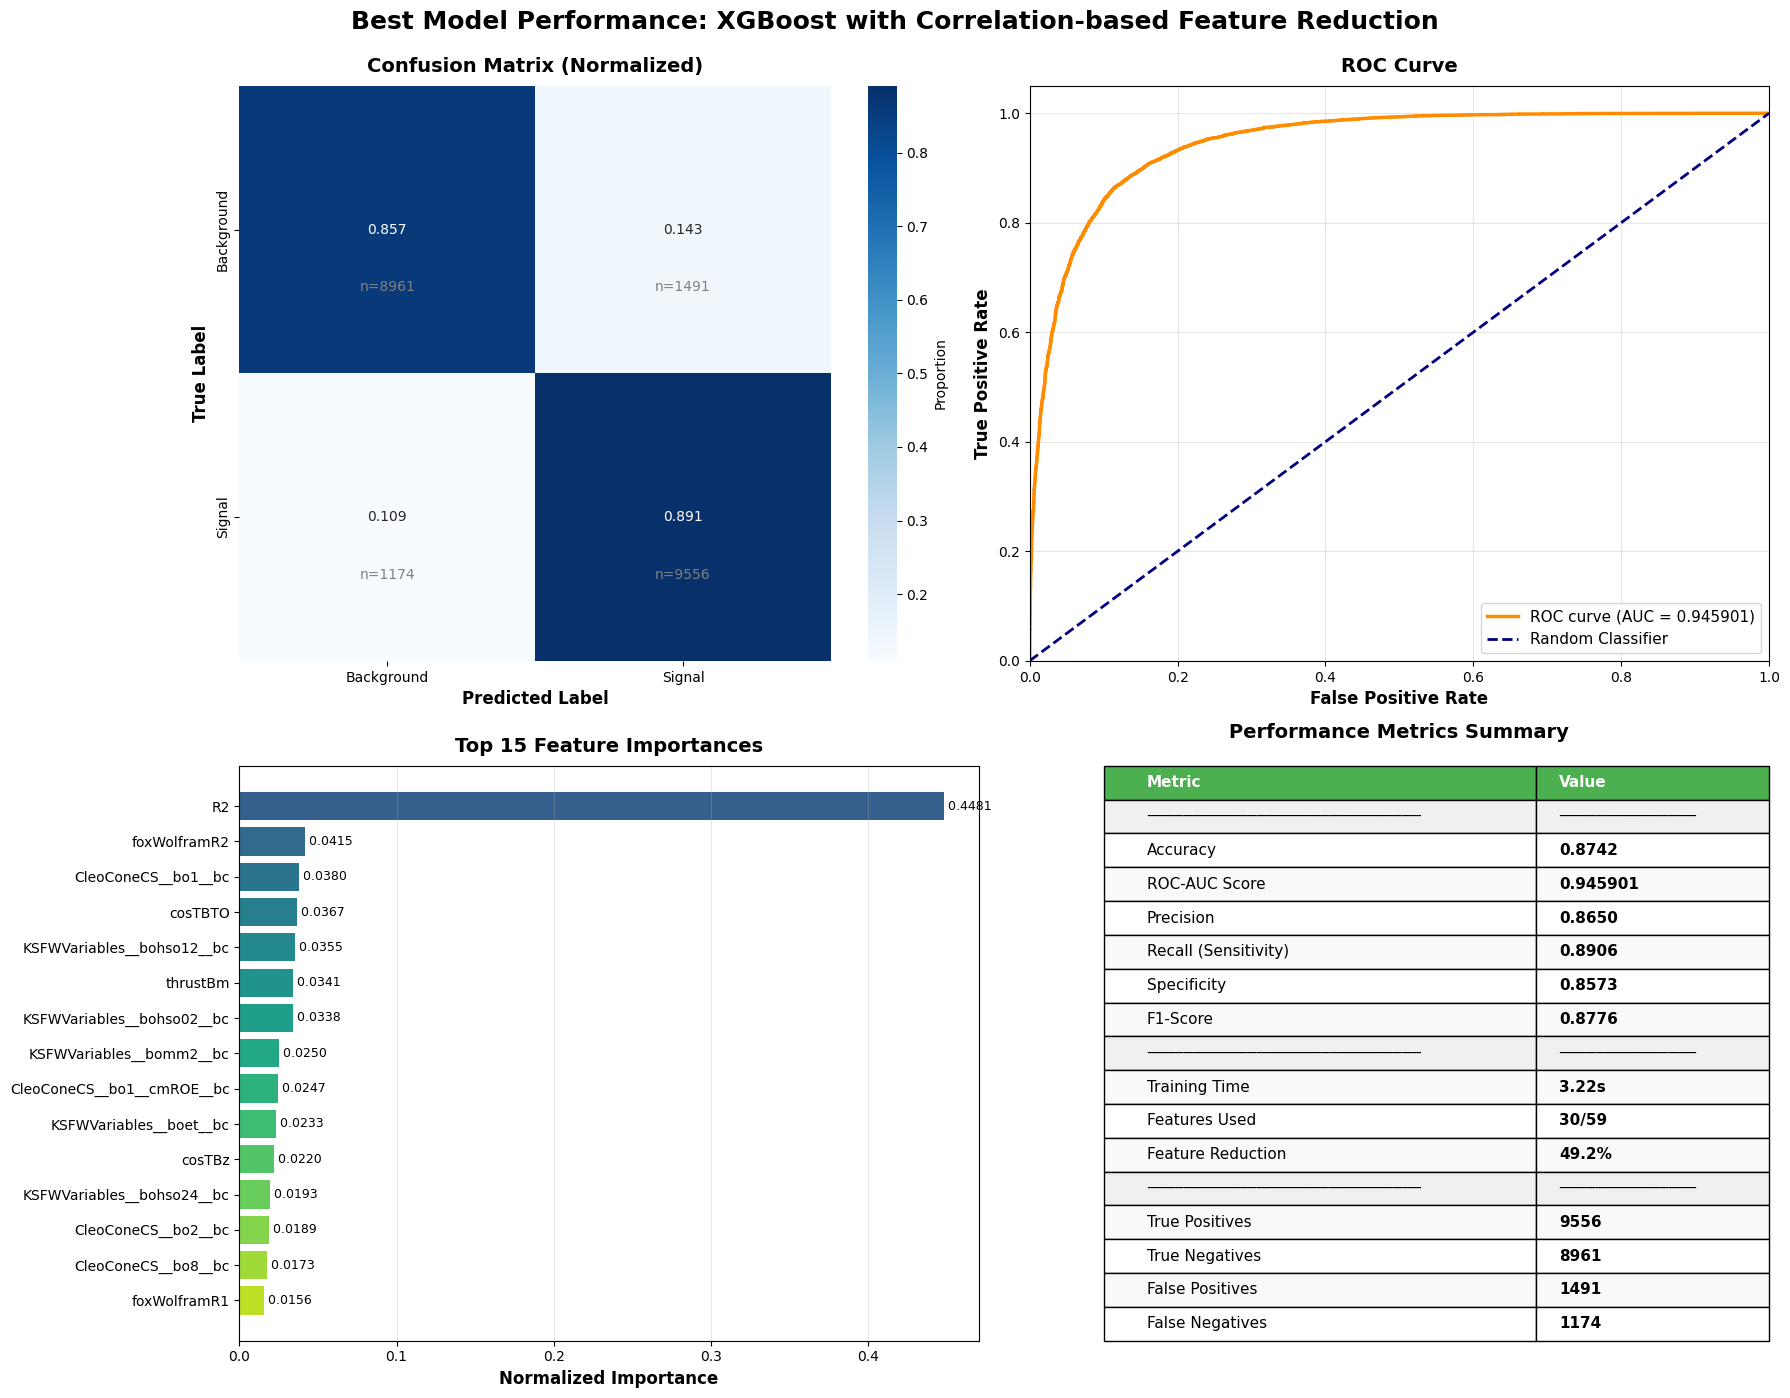

In [96]:
# Comprehensive visualization of best model results
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Best Model Performance: XGBoost with Correlation-based Feature Reduction', 
             fontsize=18, fontweight='bold', y=0.995)

# Plot 1: Confusion Matrix
ax1 = axes[0, 0]
cm = xgb_results_corr['confusion_matrix']
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues', 
            cbar_kws={'label': 'Proportion'}, ax=ax1,
            xticklabels=['Background', 'Signal'], 
            yticklabels=['Background', 'Signal'])
ax1.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax1.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
ax1.set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold', pad=10)

# Add raw counts as text
for i in range(2):
    for j in range(2):
        ax1.text(j + 0.5, i + 0.7, f'n={cm[i,j]}', 
                ha='center', va='center', fontsize=10, color='gray')

# Plot 2: ROC Curve
ax2 = axes[0, 1]
fpr, tpr, _ = xgb_results_corr['roc_curve']
roc_auc = xgb_results_corr['roc_auc_score']

ax2.plot(fpr, tpr, color='darkorange', lw=2.5, 
         label=f'ROC curve (AUC = {roc_auc:.6f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax2.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax2.set_title('ROC Curve', fontsize=14, fontweight='bold', pad=10)
ax2.legend(loc="lower right", fontsize=11)
ax2.grid(alpha=0.3)

# Plot 3: Top Feature Importances
ax3 = axes[1, 0]
feature_importance = xgb_results_corr['feature_importance']
top_n = 15
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)[:top_n]
features, importances = zip(*sorted_features)

colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(features)))
bars = ax3.barh(range(len(features)), importances, color=colors)
ax3.set_yticks(range(len(features)))
ax3.set_yticklabels(features, fontsize=10)
ax3.set_xlabel('Normalized Importance', fontsize=12, fontweight='bold')
ax3.set_title(f'Top {top_n} Feature Importances', fontsize=14, fontweight='bold', pad=10)
ax3.invert_yaxis()
ax3.grid(axis='x', alpha=0.3)

# Add value labels on bars
for i, (bar, imp) in enumerate(zip(bars, importances)):
    ax3.text(imp, i, f' {imp:.4f}', va='center', fontsize=9)

# Plot 4: Performance Metrics Summary
ax4 = axes[1, 1]
ax4.axis('off')

# Calculate additional metrics from confusion matrix
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

# Create metrics table
metrics_data = [
    ['Metric', 'Value'],
    ['─' * 30, '─' * 15],
    ['Accuracy', f'{xgb_results_corr["accuracy"]:.4f}'],
    ['ROC-AUC Score', f'{xgb_results_corr["roc_auc_score"]:.6f}'],
    ['Precision', f'{precision:.4f}'],
    ['Recall (Sensitivity)', f'{recall:.4f}'],
    ['Specificity', f'{specificity:.4f}'],
    ['F1-Score', f'{f1_score:.4f}'],
    ['─' * 30, '─' * 15],
    ['Training Time', f'{xgb_results_corr["training_time"]:.2f}s'],
    ['Features Used', f'{len(selected_features_corr)}/59'],
    ['Feature Reduction', f'{(1 - len(selected_features_corr)/59)*100:.1f}%'],
    ['─' * 30, '─' * 15],
    ['True Positives', f'{tp}'],
    ['True Negatives', f'{tn}'],
    ['False Positives', f'{fp}'],
    ['False Negatives', f'{fn}'],
]

# Display table
table = ax4.table(cellText=metrics_data, cellLoc='left', loc='center',
                  colWidths=[0.65, 0.35],
                  bbox=[0.1, 0, 0.9, 1])
table.auto_set_font_size(False)
table.set_fontsize(11)

# Style the table
for i, key in enumerate(metrics_data):
    cell = table[(i, 0)]
    if i == 0:  # Header
        cell.set_facecolor('#4CAF50')
        cell.set_text_props(weight='bold', color='white')
        table[(i, 1)].set_facecolor('#4CAF50')
        table[(i, 1)].set_text_props(weight='bold', color='white')
    elif i in [1, 8, 12]:  # Separator rows
        cell.set_facecolor('#f0f0f0')
        table[(i, 1)].set_facecolor('#f0f0f0')
    else:
        cell.set_facecolor('#ffffff' if i % 2 == 0 else '#f9f9f9')
        table[(i, 1)].set_facecolor('#ffffff' if i % 2 == 0 else '#f9f9f9')
        if i > 1:
            table[(i, 1)].set_text_props(weight='bold')

ax4.set_title('Performance Metrics Summary', fontsize=14, fontweight='bold', 
              pad=20, loc='center')

plt.tight_layout()
plt.savefig('plots/best_model_results.png', dpi=300, bbox_inches='tight')
print(f"✅ Visualization saved to plots/best_model_results.png")
plt.show()
